In [1]:
import pandas as pd
import numpy as np
import copy

import math
import scipy.stats as stats

import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

# !pip install pypsa
import pypsa
# !pip install cartopy
import cartopy

import warnings
warnings.filterwarnings('ignore')

C:\Users\ywu\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


INFO:pypsa.io:Imported network ac-dc-meshed.nc has buses, carriers, generators, global_constraints, lines, links, loads


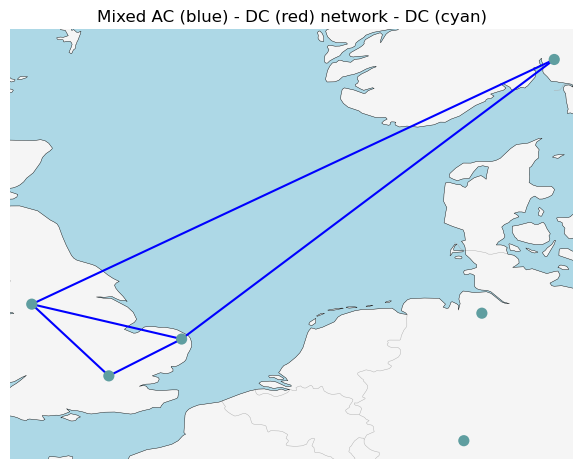

In [2]:
# Create a network with only AC lines

network_sample = pypsa.examples.ac_dc_meshed(from_master=True)

network = pypsa.Network()

network.buses = copy.deepcopy(network_sample.buses[network_sample.buses['carrier'] == 'AC'])

network.lines = copy.deepcopy(network_sample.lines.iloc[[0, 1, 5],])
network.lines.index = ['London-Manchester', 'Manchester-Norwich', 'Norwich-London']
network.add('Line', 'Norway-Norwich', bus0='Norway', bus1='Norwich', \
            capital_cost=0.15, s_nom=40000, s_nom_extendable=True, x=0.55, r=0)
network.add('Line', 'Norway-Manchester', bus0='Norway', bus1='Manchester', \
            capital_cost=0.16, s_nom=40000, s_nom_extendable=True, x=0.6, r=0)

network.generators = copy.deepcopy(network_sample.generators)

n = network
n.plot(
    line_colors=n.lines.bus0.map(n.buses.carrier).map(lambda ct: "r" if ct == "DC" else "b"),
    title="Mixed AC (blue) - DC (red) network - DC (cyan)",
    color_geomap=True,
    jitter=0.3,
)
plt.tight_layout()

In [3]:
# Buses in the network

# name: Unique name
# v_nom: Nominal voltage
# x: Position (e.g. longitude)
# y: Position (e.g. latitude)
# carrier: Energy carrier (AC or DC for electrical buses, or heat or gas)

# How to add a bus
# network.add('Bus', 'Name', v_nom=...)

network.buses

,v_nom,carrier,x,y,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
London,380.0,AC,-0.13,51.50,,None,1.0,0.0,inf,PQ,
Norwich,380.0,AC,1.30,52.60,,None,1.0,0.0,inf,PQ,
Manchester,380.0,AC,-2.20,53.47,,None,1.0,0.0,inf,PQ,
Bremen,380.0,AC,8.80,53.08,,None,1.0,0.0,inf,PQ,
Frankfurt,380.0,AC,8.70,50.12,,None,1.0,0.0,inf,PQ,
Norway,380.0,AC,10.75,60.00,,None,1.0,0.0,inf,PQ,


In [4]:
# Lines in the network

# name: Unique name
# bus0 and bus1: Buses to which line is attached
# x: Series reactance, must be non-zero for AC branch in linear power flow
# r: Series resistance, must be non-zero for DC branch in linear power flow
# s_nom: Limit of apparent power which can pass through line
# capital_cost: Capital cost of extending s_nom by 1 MVA

# How to add a line
# network.add('Line', 'Name', bus0=...)

network.lines['s_nom'] = 8000
network.lines['s_nom_extendable'] = False
network.lines

,bus0,bus1,capital_cost,s_nom,s_nom_extendable,x,r,type,g,b,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
London-Manchester,London,Manchester,0.136716,8000,False,0.796878,0.0,,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Manchester-Norwich,Manchester,Norwich,0.133492,8000,False,0.391560,0.0,,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Norwich-London,Norwich,London,0.021852,8000,False,0.238800,0.0,,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Norway-Norwich,Norway,Norwich,0.150000,8000,False,0.550000,0.0,,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Norway-Manchester,Norway,Manchester,0.160000,8000,False,0.600000,0.0,,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Generators in the network

# name: Unique name
# bus: Bus to which generator is attached
# p_nom: Nominal power for limits in optimization
# carrier: Prime mover energy carrier (e.g. coal, gas, wind, solar)
# marginal_cost: Marginal cost of production of 1 MWh
# capital_cost: Capital cost of extending p_nom by 1 MW
# efficiency: Ratio between primary energy and electrical energy

# How to add a generator
# network.add('Generator', 'Name', bus=...)

network.generators

,bus,capital_cost,efficiency,marginal_cost,p_nom,p_nom_extendable,p_nom_min,carrier,control,type,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Manchester Wind,Manchester,2793.651603,1.000000,0.110000,80.0,True,100.0,wind,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Manchester Gas,Manchester,196.615168,0.350026,4.532368,50000.0,True,0.0,gas,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Norway Wind,Norway,2184.374796,1.000000,0.090000,100.0,True,100.0,wind,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Norway Gas,Norway,158.251250,0.356836,5.892845,20000.0,True,0.0,gas,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Frankfurt Wind,Frankfurt,2129.456122,1.000000,0.100000,110.0,True,100.0,wind,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Frankfurt Gas,Frankfurt,102.676953,0.351666,4.086322,80000.0,True,0.0,gas,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [6]:
# Loads in the network

# name, bus, carrier, p_set, q_set seems to be necessary for generators
# name: Unique name
# bus: Bus to which load is attached
# carrier: Energy carrier (AC or DC for electrical buses, or heat or gas)
# p_set: Active power consumption
# q_set: Reactive power consumption

# How to add a load
# network.add('Load', 'Name', bus=...)

network.loads = pd.DataFrame()
network.add('Load', 'Load London', bus='London', p_set=10000)
network.add('Load', 'Load Norwich', bus='Norwich', p_set=10000)
network.add('Load', 'Load Manchester', bus='Manchester', p_set=10000)
network.add('Load', 'Load Bremen', bus='Bremen', p_set=10000)
network.add('Load', 'Load Frankfurt', bus='Frankfurt', p_set=10000)
network.add('Load', 'Load Norway', bus='Norway', p_set=10000)
network.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
Load London,London,,,10000.0,0.0,-1.0
Load Norwich,Norwich,,,10000.0,0.0,-1.0
Load Manchester,Manchester,,,10000.0,0.0,-1.0
Load Bremen,Bremen,,,10000.0,0.0,-1.0
Load Frankfurt,Frankfurt,,,10000.0,0.0,-1.0
Load Norway,Norway,,,10000.0,0.0,-1.0


In [7]:
# Newton-Raphson Power Flow Model

network.pf()

# Error in running Power Flow Model

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.010996 seconds
INFO:pypsa.pf:Balancing power on single-bus sub-network SubNetwork 1 for snapshots Index(['now'], dtype='object', name='snapshot')


KeyError: None

In [8]:
# Optimal Power Flow Model

network.optimize()

# Error in running Optimal Power Flow Model

Index(['London-Manchester', 'Manchester-Norwich', 'Norwich-London',
       'Norway-Norwich', 'Norway-Manchester'],
      dtype='object', name='Line')
Index(['London-Manchester', 'Manchester-Norwich', 'Norwich-London',
       'Norway-Norwich', 'Norway-Manchester'],
      dtype='object', name='Line')


ValueError: Empty LHS with non-zero RHS in nodal balance constraint.